In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno
import os, warnings

from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
import shap

## **Prédiction pour la variable 'TotalGHGEmissions'**

## I- Visualisation des données

In [2]:
#Chargement du jeu de données
df = pd.read_csv('Data_Cleaned.csv')

#Afficher le dataset
print(df.head())

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0            12.0                 0.0   
1                1.0            11.0             15064.0   
2                1.0            41.0            196718.0   
3                1.0            10.0                 0.0   
4                1.0            18.0             62000.0   

   PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
0                 88434.0             60.0              7456910.0   
1                 88502.0             61.0              8664479.0   
2                759392.0             43.0             73937112.0   
3                 61320.0             56.0              6946800.5   
4                113580.0             75.0             14656503.0   

   TotalGHGEmissions  BuildingAge  SteamProportion  ElectricityProportion  \
0             249.98         89.0         0.277302               0.546060   
1             295.86         20.0         0.000000               0.386

In [3]:
# Combien de lignes et de colonnes sont contenus dans df
print('Shape : ' + str(df.shape))

Shape : (1543, 38)


In [4]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(df.info(verbose=True))
print(df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   NumberofBuildings                          1543 non-null   float64
 1   NumberofFloors                             1543 non-null   float64
 2   PropertyGFAParking                         1543 non-null   float64
 3   PropertyGFABuilding(s)                     1543 non-null   float64
 4   ENERGYSTARScore                            1543 non-null   float64
 5   SiteEnergyUseWN(kBtu)                      1543 non-null   float64
 6   TotalGHGEmissions                          1543 non-null   float64
 7   BuildingAge                                1543 non-null   float64
 8   SteamProportion                            1543 non-null   float64
 9   ElectricityProportion                      1543 non-null   float64
 10  NaturalGasProportion    

In [5]:
df.describe()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,SteamProportion,ElectricityProportion,NaturalGasProportion,LargestPropertyUseTypeGFAProportion,SecondLargestPropertyUseTypeGFAProportion,ThirdLargestPropertyUseTypeGFAProportion
count,1543.000000,1543.000000,1543.000000,1.543000e+03,1543.000000,1.543000e+03,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000
mean,1.225164,4.347838,13830.705120,1.076473e+05,63.355893,8.455270e+06,194.002191,54.322100,0.022584,0.699613,0.273874,0.861325,0.126327,0.023222
std,3.041175,6.817131,43747.147997,2.930837e+05,24.563086,2.280459e+07,780.330309,32.864014,0.094192,0.264834,0.264196,0.312595,0.172106,0.063820
min,1.000000,1.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,-0.800000,1.000000,0.000000,-0.336762,0.000000,0.186469,0.000000,0.000000
25%,1.000000,1.000000,0.000000,2.792050e+04,49.071429,1.322090e+06,20.550000,27.000000,0.000000,0.489953,0.000000,0.672986,0.000000,0.000000
50%,1.000000,2.000000,0.000000,4.606800e+04,66.285714,2.811924e+06,49.900000,50.000000,0.000000,0.705181,0.231882,0.940499,0.000000,0.000000
75%,1.000000,4.000000,0.000000,9.571050e+04,82.000000,7.509929e+06,147.315000,86.000000,0.000000,0.999988,0.489359,1.000000,0.244166,0.000000
max,111.000000,99.000000,512608.000000,9.320156e+06,100.000000,4.716139e+08,16870.980000,116.000000,0.766987,1.000003,1.000000,6.426849,1.452054,0.929094


## II- Préparation des données

### 1) Création de la variable discrète

In [6]:
df['TotalGHGEmissionsDisc'] = pd.qcut(df['TotalGHGEmissions'], q=10, labels=False)

### 2) X et y

In [7]:
#On sépare X et y
X = df.drop(columns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'TotalGHGEmissionsDisc', 'ENERGYSTARScore'])
y = df['TotalGHGEmissions']

In [8]:
print(X.head())
print(y.head())

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0            12.0                 0.0   
1                1.0            11.0             15064.0   
2                1.0            41.0            196718.0   
3                1.0            10.0                 0.0   
4                1.0            18.0             62000.0   

   PropertyGFABuilding(s)  BuildingAge  SteamProportion  \
0                 88434.0         89.0         0.277302   
1                 88502.0         20.0         0.000000   
2                759392.0         47.0         0.297113   
3                 61320.0         90.0         0.325913   
4                113580.0         36.0         0.000000   

   ElectricityProportion  NaturalGasProportion  \
0               0.546060              0.176638   
1               0.386609              0.613391   
2               0.682307              0.020579   
3               0.407519              0.266567   
4               0.378802          

### 3) Test train split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify= df['TotalGHGEmissionsDisc'],
                                                    random_state=20)

In [10]:
print(f'Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}  ')
print(f'Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}  ')

Nous avons X_train de forme (1234, 35) et y_train de forme (1234,)  
Nous avons X_test de forme (309, 35) et y_test de forme (309,)  


In [11]:
X_train

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,SteamProportion,ElectricityProportion,NaturalGasProportion,LargestPropertyUseTypeGFAProportion,SecondLargestPropertyUseTypeGFAProportion,...,PrimaryType_Worship Facility,Neighborhood_CENTRAL,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHWEST
573,1.0,2.0,0.0,51856.0,8.0,0.0,1.000000,0.000000,0.927627,0.072373,...,False,False,False,False,True,False,False,False,False,False
1150,1.0,1.0,0.0,29394.0,24.0,0.0,0.768119,0.231882,1.000000,0.000000,...,False,False,False,False,True,False,False,False,False,False
874,1.0,1.0,0.0,23562.0,59.0,0.0,1.000000,0.000000,0.775741,0.645616,...,True,False,False,False,False,False,False,False,False,True
1468,8.0,3.0,0.0,502030.0,87.0,0.0,0.506752,0.493248,1.123953,0.000000,...,False,False,False,False,False,False,False,True,False,False
255,1.0,14.0,407795.0,282363.0,24.0,0.0,1.000000,0.000000,0.391771,0.391770,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.0,7.0,8296.0,106099.0,107.0,0.0,0.597361,0.402638,0.844285,0.000000,...,False,False,True,False,False,False,False,False,False,False
527,1.0,1.0,0.0,141686.0,46.0,0.0,1.000000,0.000000,1.076401,0.000000,...,False,False,False,False,True,False,False,False,False,False
697,1.0,2.0,0.0,31000.0,46.0,0.0,0.963396,0.036604,1.000000,0.000000,...,False,False,False,False,True,False,False,False,False,False
778,1.0,1.0,0.0,20236.0,55.0,0.0,0.604231,0.395769,1.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False


In [12]:
y_train

573      13.51
1150     26.27
874       3.71
1468    549.11
255     147.49
         ...  
187      70.17
527      46.52
697      19.93
778      49.58
618      13.87
Name: TotalGHGEmissions, Length: 1234, dtype: float64

## III- Modélisation et évaluation des modèles

In [13]:
def train_and_predict(estimator, X_train, y_train, X_test):
    '''Entraînement et prédiction des modèles'''
    start_time = time.time()
    estimator.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = estimator.predict(X_test)
    return training_time, y_pred

def evaluate_model(y_true, y_pred, model_name, training_time):
    '''évaluation des modèles'''
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - R2: {r2:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}")
    print(f"Training Time ({model_name}): {training_time:.2f} seconds\n")  

### 1) Données sans optimisation

In [14]:
# Dummy Regressor
dummy_estimator = DummyRegressor(strategy='mean')
training_time_dummy, y_pred_dummy = train_and_predict(dummy_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_dummy, "Dummy Regressor", training_time_dummy)

# Linear Regression
lr_estimator = LinearRegression()
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
lasso_estimator = Lasso()
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
ridge_estimator = Ridge()
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
elasticnet_estimator = ElasticNet()
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
rf_estimator = RandomForestRegressor()
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
gb_estimator = GradientBoostingRegressor()
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
xgb_estimator = XGBRegressor()
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

Dummy Regressor - R2: -0.00, RMSE: 583.06, MSE: 339958.83, MAE: 214.62
Training Time (Dummy Regressor): 0.00 seconds

Linear Regression - R2: 0.15, RMSE: 537.96, MSE: 289398.31, MAE: 238.30
Training Time (Linear Regression): 0.21 seconds

Lasso - R2: 0.21, RMSE: 518.66, MSE: 269010.84, MAE: 219.23
Training Time (Lasso): 0.00 seconds

Ridge - R2: 0.25, RMSE: 505.35, MSE: 255383.35, MAE: 218.22
Training Time (Ridge): 0.04 seconds

ElasticNet - R2: 0.29, RMSE: 490.24, MSE: 240334.20, MAE: 157.86
Training Time (ElasticNet): 0.02 seconds

Random Forest Regressor - R2: 0.21, RMSE: 516.86, MSE: 267143.45, MAE: 130.63
Training Time (Random Forest Regressor): 2.71 seconds

Gradient Boosting Regressor - R2: 0.52, RMSE: 403.15, MSE: 162532.55, MAE: 118.98
Training Time (Gradient Boosting Regressor): 0.61 seconds

XGBoost Regressor - R2: -1.88, RMSE: 989.76, MSE: 979631.34, MAE: 150.06
Training Time (XGBoost Regressor): 0.89 seconds



### 2) Transformation des variables

In [15]:
colonnes_scaler = X.select_dtypes(['int32', 'float64']).drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)']).columns

scaler = StandardScaler()
log_transformer = FunctionTransformer(func=lambda x: np.log10(x + 1))

#Preprocessor
preprocessor = ColumnTransformer([
    ('scaler', scaler, colonnes_scaler),
    ('log_transform', log_transformer, ['PropertyGFAParking', 'PropertyGFABuilding(s)'])
], remainder='passthrough')

#Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

#Transformation des données
X_train_preprocessed = pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)

X_test_preprocessed = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

In [16]:
# Box-Cox() de la target
transformer = PowerTransformer(method='box-cox', standardize=False)
y_train = transformer.fit_transform(y_train.values.reshape(-1, 1) +1).flatten()
y_test = transformer.transform(y_test.values.reshape(-1, 1)+1).flatten()

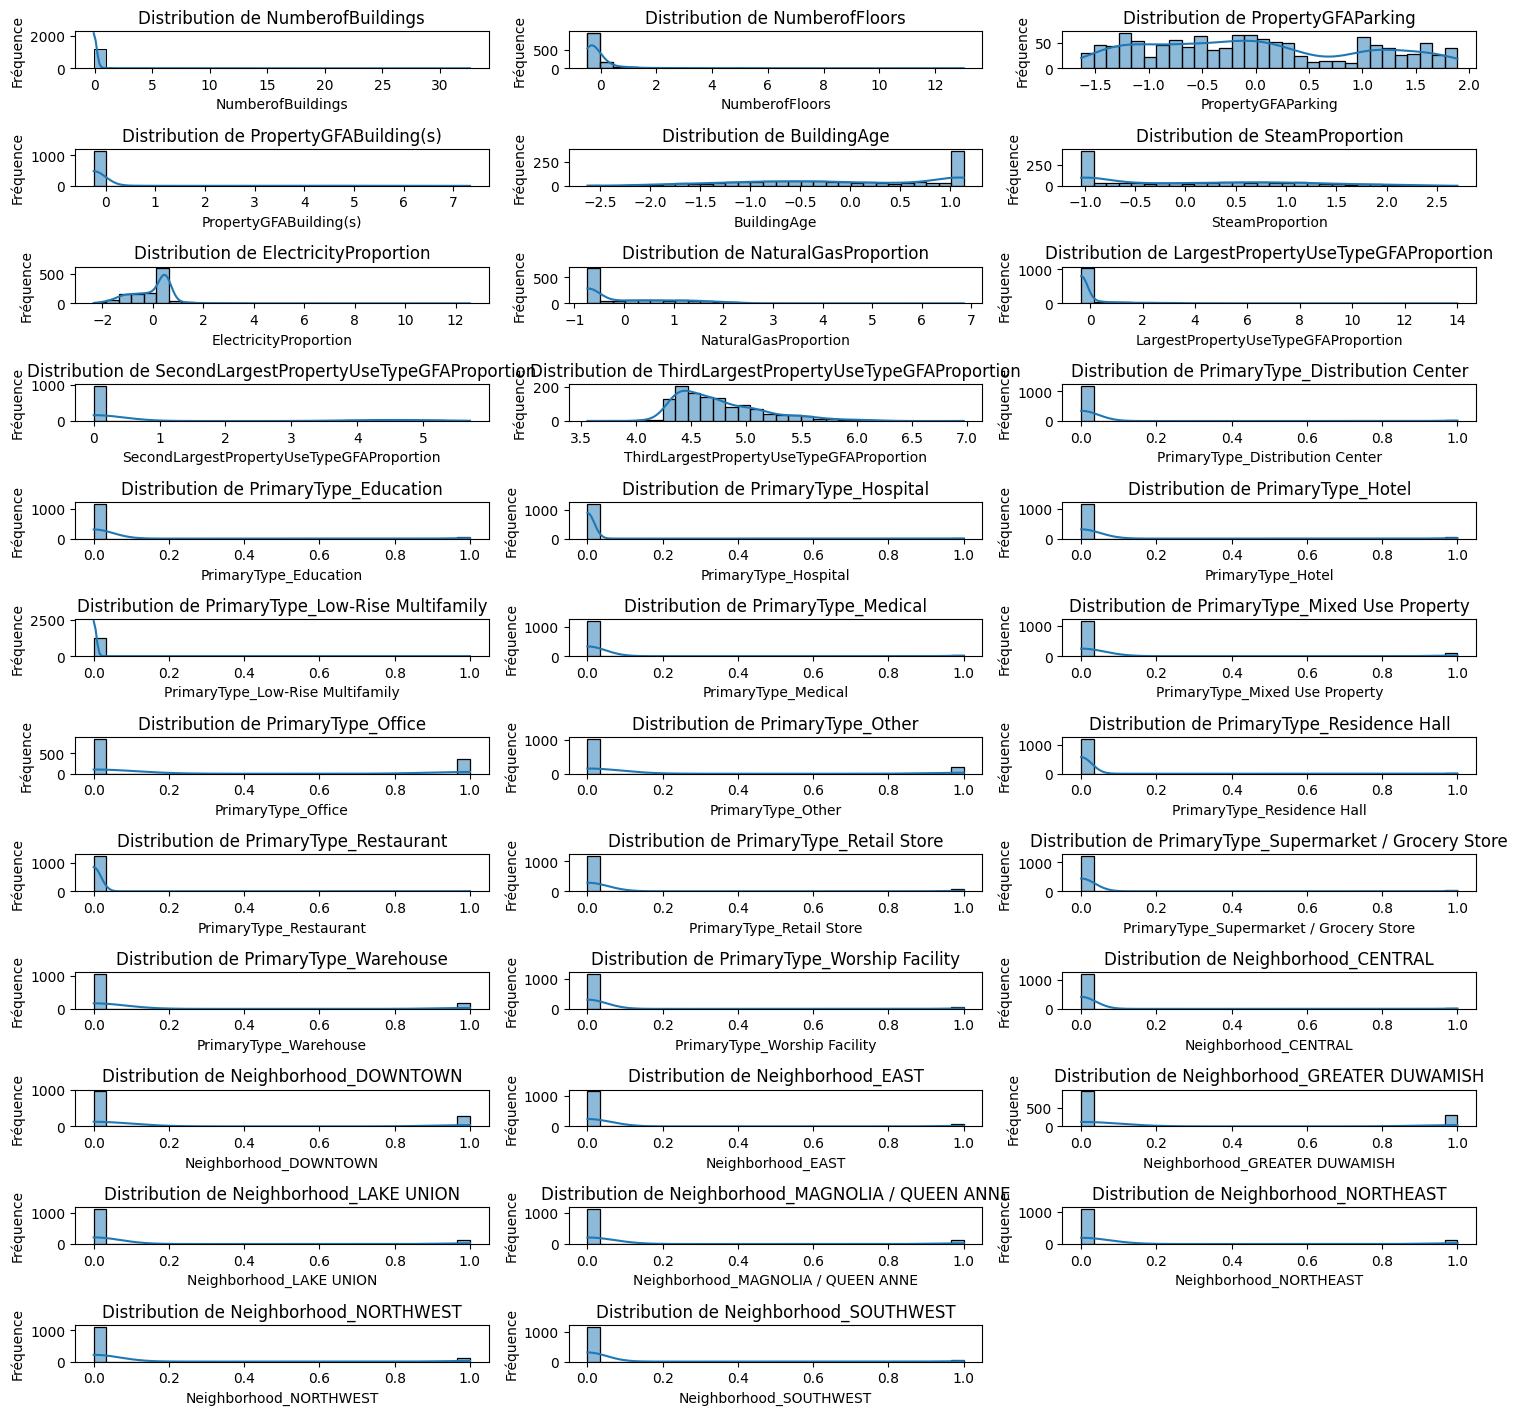

In [17]:
plt.figure(figsize=(15, 15))
for i, colonne in enumerate(X_train):
    plt.subplot(13, 3, i+1)
    sns.histplot(X_train[colonne], kde=True, bins=30)
    plt.title(f'Distribution de {colonne}')
    plt.xlabel(colonne)
    plt.ylabel('Fréquence')
    plt.tight_layout()
plt.show()

In [18]:
# Dummy Regressor
dummy_estimator = DummyRegressor(strategy='mean')
training_time_dummy, y_pred_dummy = train_and_predict(dummy_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_dummy, "Dummy Regressor", training_time_dummy)

# Linear Regression
lr_estimator = LinearRegression()
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
lasso_estimator = Lasso()
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
ridge_estimator = Ridge()
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
elasticnet_estimator = ElasticNet()
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
rf_estimator = RandomForestRegressor()
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
gb_estimator = GradientBoostingRegressor()
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
xgb_estimator = XGBRegressor()
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

Dummy Regressor - R2: -0.00, RMSE: 1.20, MSE: 1.43, MAE: 0.94
Training Time (Dummy Regressor): 0.00 seconds

Linear Regression - R2: 0.78, RMSE: 0.57, MSE: 0.32, MAE: 0.42
Training Time (Linear Regression): 0.01 seconds

Lasso - R2: -0.00, RMSE: 1.20, MSE: 1.43, MAE: 0.94
Training Time (Lasso): 0.00 seconds

Ridge - R2: 0.78, RMSE: 0.56, MSE: 0.32, MAE: 0.42
Training Time (Ridge): 0.00 seconds

ElasticNet - R2: -0.00, RMSE: 1.20, MSE: 1.43, MAE: 0.94
Training Time (ElasticNet): 0.00 seconds

Random Forest Regressor - R2: 0.74, RMSE: 0.61, MSE: 0.37, MAE: 0.44
Training Time (Random Forest Regressor): 2.29 seconds

Gradient Boosting Regressor - R2: 0.78, RMSE: 0.57, MSE: 0.32, MAE: 0.41
Training Time (Gradient Boosting Regressor): 0.58 seconds

XGBoost Regressor - R2: 0.75, RMSE: 0.60, MSE: 0.35, MAE: 0.43
Training Time (XGBoost Regressor): 0.21 seconds



## IV- Optimisation

In [19]:
def resultize(grid):
    '''make a fancy df from grid_.cv_results'''
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    return res

def grid_search(estimator, param_grid, X_train, y_train):
    '''recherche sur grille'''
    grid = GridSearchCV(estimator,
                        param_grid,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True,
                        verbose=1)
    grid.fit(X_train, y_train)
    print("Best Score:", grid.best_score_)
    print("Best Params:", grid.best_params_)
    return grid

### 1) Regression linéaire

In [20]:
lr = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False],  
    'copy_X': [True, False], 
}

In [21]:
grid_lr = grid_search(lr, param_grid_lr, X_train, y_train)
results_lr = resultize(grid_lr)
lr_estimator = LinearRegression(**grid_lr.best_params_)
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score: 0.78602352298953
Best Params: {'copy_X': True, 'fit_intercept': True}


In [22]:
pd.set_option('display.max_columns', None)
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018753,0.006248,0.003126,0.006251,True,True,"{'copy_X': True, 'fit_intercept': True}",0.759298,0.792673,0.824082,0.775813,0.778251,0.786024,0.021779,1,0.818679,0.811214,0.803855,0.809500,0.813551,0.811360,0.004861
1,0.015625,0.013976,0.003125,0.006251,True,False,"{'copy_X': True, 'fit_intercept': False}",0.759298,0.792673,0.824082,0.759429,0.778251,0.782747,0.024170,3,0.818679,0.811214,0.803855,0.809500,0.813551,0.811360,0.004861
2,0.006250,0.007654,0.006251,0.007655,False,True,"{'copy_X': False, 'fit_intercept': True}",0.759298,0.792673,0.824082,0.775813,0.778251,0.786024,0.021779,1,-52.406110,-50.754479,-52.529072,-52.790919,-54.356206,-52.567357,1.145771
3,0.000000,0.000000,0.009374,0.007654,False,False,"{'copy_X': False, 'fit_intercept': False}",0.759298,0.792673,0.824082,0.759429,0.778251,0.782747,0.024170,3,0.818679,0.811214,0.803855,0.809500,0.813551,0.811360,0.004861


### 2) Lasso

In [23]:
lasso_estimator = Lasso()

param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0],  
    'fit_intercept': [True, False], 
}

In [24]:
grid_lasso = grid_search(lasso_estimator, param_grid_lasso, X_train, y_train)
results_lasso = resultize(grid_lasso)
lasso_estimator = Lasso(**grid_lasso.best_params_)
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 0.6280458833519027
Best Params: {'alpha': 0.1, 'fit_intercept': True}


### 3) Ridge

In [25]:
ridge_estimator = Ridge()

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],  
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'],
}

In [26]:
grid_ridge = grid_search(ridge_estimator, param_grid_ridge, X_train, y_train)
results_ridge = resultize(grid_ridge)
ridge_estimator = Ridge(**grid_ridge.best_params_)
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score: 0.7860333293795096
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'lsqr'}


### 4) ElasticNet Regression

In [27]:
elasticnet_estimator = ElasticNet()

param_grid_elasticnet = {
    'alpha': [0.1, 1.0, 10.0],  
    'l1_ratio': [0.1, 0.5, 0.9],
    'fit_intercept': [True, False]
}

In [28]:
grid_elasticnet = grid_search(elasticnet_estimator, param_grid_elasticnet, X_train, y_train)
results_elasticnet = resultize(grid_elasticnet)
elasticnet_estimator = ElasticNet(**grid_elasticnet.best_params_)
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score: 0.6765059486079201
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.1}


### 5) Random Forest Regressor

In [29]:
rf_estimator = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13]
}

In [30]:
grid_rf = grid_search(rf_estimator, param_grid_rf, X_train, y_train)
results_rf = resultize(grid_rf)
rf_estimator = RandomForestRegressor(**grid_rf.best_params_)
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score: 0.7810454355512418
Best Params: {'max_depth': 13, 'n_estimators': 300}


### 6) Gradient Boosting Regressor

In [31]:
gb_estimator = GradientBoostingRegressor()

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [32]:
grid_gb = grid_search(gb_estimator, param_grid_gb, X_train, y_train)
results_gb = resultize(grid_gb)
gb_estimator = GradientBoostingRegressor(**grid_gb.best_params_)
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.7974386901817745
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


### 7) XGBoost Regressor

In [33]:
xgb_estimator = XGBRegressor()

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [34]:
grid_xgb = grid_search(xgb_estimator, param_grid_xgb, X_train, y_train)
results_xgb = resultize(grid_xgb)
xgb_estimator = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.8058902753231024
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


### 8) Evaluation des modèles

In [35]:
# Linear Regression
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

Linear Regression - R2: 0.78, RMSE: 0.57, MSE: 0.32, MAE: 0.42
Training Time (Linear Regression): 0.00 seconds

Lasso - R2: 0.51, RMSE: 0.84, MSE: 0.70, MAE: 0.58
Training Time (Lasso): 0.00 seconds

Ridge - R2: 0.78, RMSE: 0.57, MSE: 0.32, MAE: 0.42
Training Time (Ridge): 0.00 seconds

ElasticNet - R2: 0.62, RMSE: 0.74, MSE: 0.55, MAE: 0.54
Training Time (ElasticNet): 0.01 seconds

Random Forest Regressor - R2: 0.74, RMSE: 0.61, MSE: 0.37, MAE: 0.44
Training Time (Random Forest Regressor): 5.60 seconds

Gradient Boosting Regressor - R2: 0.79, RMSE: 0.55, MSE: 0.30, MAE: 0.40
Training Time (Gradient Boosting Regressor): 1.16 seconds

XGBoost Regressor - R2: 0.78, RMSE: 0.56, MSE: 0.31, MAE: 0.39
Training Time (XGBoost Regressor): 0.26 seconds



Sur la base du best_score obtenu avec GridSearch, le modèle **XGBoost Regressor** est le meilleur choix.

## V- Impact de L'ENERGYStarScore

In [36]:
X_ESS = df.drop(columns = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'TotalGHGEmissionsDisc'])
y_ESS = df['TotalGHGEmissions']

In [37]:
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS,
                                                    y_ESS,
                                                    test_size=0.2,
                                                    stratify= df['TotalGHGEmissionsDisc'],
                                                    random_state=20)

In [38]:
colonnes_scaler = X_ESS.select_dtypes(['int32', 'float64']).drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)']).columns

scaler = StandardScaler()
log_transformer = FunctionTransformer(func=lambda x: np.log10(x + 1))

#Preprocessor
preprocessor = ColumnTransformer([
    ('scaler', scaler, colonnes_scaler),
    ('log_transform', log_transformer, ['PropertyGFAParking', 'PropertyGFABuilding(s)'])
], remainder='passthrough')

#Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

#Transformation des données
X_train_preprocessed_ESS = pipeline.fit_transform(X_train_ESS)
X_train_ESS = pd.DataFrame(X_train_preprocessed_ESS, columns=X_train_ESS.columns)

X_test_preprocessed_ESS = pipeline.transform(X_test_ESS)
X_test_ESS = pd.DataFrame(X_test_preprocessed_ESS, columns=X_test_ESS.columns)

In [39]:
# Box-Cox() de la target
transformer = PowerTransformer(method='box-cox', standardize=False)
y_train_ESS = transformer.fit_transform(y_train_ESS.values.reshape(-1, 1) +1).flatten()
y_test_ESS = transformer.transform(y_test_ESS.values.reshape(-1, 1)+1).flatten()

In [40]:
xgb_estimator = XGBRegressor()

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [41]:
grid_xgb = grid_search(xgb_estimator, param_grid_xgb, X_train_ESS, y_train_ESS)
results_xgb = resultize(grid_xgb)
xgb_estimator = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_ESS, y_pred_xgb_ESS = train_and_predict(xgb_estimator, X_train_ESS, y_train_ESS, X_test_ESS)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.8568992405956773
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [42]:
# XGBoost Regressor
evaluate_model(y_test_ESS, y_pred_xgb_ESS, "XGBoost Regressor", training_time_xgb_ESS)

XGBoost Regressor - R2: 0.82, RMSE: 0.50, MSE: 0.25, MAE: 0.35
Training Time (XGBoost Regressor): 0.38 seconds



La modèle avec l'EnergyStarScore offre de meilleures performances que le modèle de base. On continue l'étude avec le modèle intégrant l'EnergyStarScore.

## VI- Impact des features sur le modèle

### 1) Feature importance

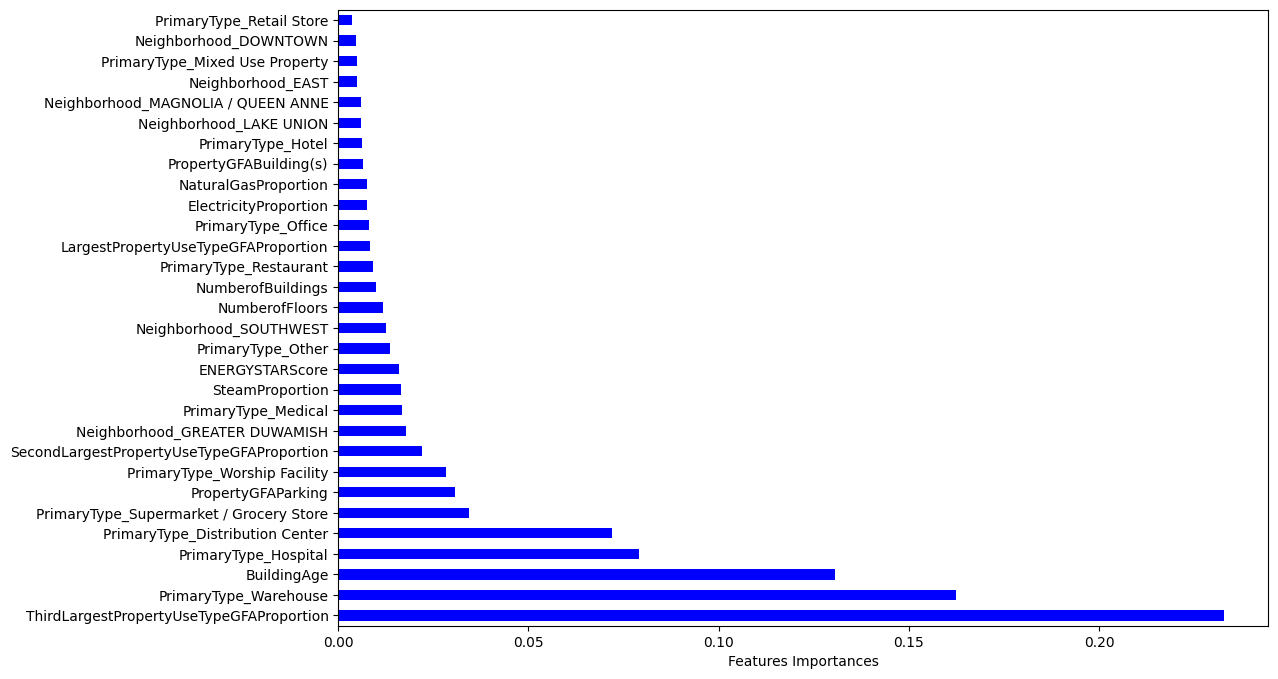

In [43]:
features_importances = pd.Series(xgb_estimator.feature_importances_, index = X_train_ESS.columns)
plt.figure(figsize=(12,8))
features_importances.nlargest(30).plot(kind='barh', color='b')

plt.xlabel('Features Importances')
plt.show()

In [44]:
features_importances.sort_values(ascending=False)

ThirdLargestPropertyUseTypeGFAProportion     0.232803
PrimaryType_Warehouse                        0.162374
BuildingAge                                  0.130465
PrimaryType_Hospital                         0.079025
PrimaryType_Distribution Center              0.072068
PrimaryType_Supermarket / Grocery Store      0.034493
PropertyGFAParking                           0.030680
PrimaryType_Worship Facility                 0.028430
SecondLargestPropertyUseTypeGFAProportion    0.022067
Neighborhood_GREATER DUWAMISH                0.017784
PrimaryType_Medical                          0.016745
SteamProportion                              0.016516
ENERGYSTARScore                              0.015885
PrimaryType_Other                            0.013703
Neighborhood_SOUTHWEST                       0.012534
NumberofFloors                               0.011734
NumberofBuildings                            0.009828
PrimaryType_Restaurant                       0.009022
LargestPropertyUseTypeGFAPro

In [45]:
# Recalcul du modèle en tenant compte des features importance
top_features = features_importances.nlargest(20).index.tolist()
X_train_top_features = X_train_ESS[top_features]
X_test_top_features = X_test_ESS[top_features]

xgb_estimator_top_features = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_top_features, y_pred_xgb_ESS_top_features = train_and_predict(xgb_estimator_top_features, X_train_top_features, y_train_ESS, X_test_top_features)
evaluate_model(y_test_ESS, y_pred_xgb_ESS_top_features, "XGBoost Regressor with Top Features", training_time_xgb_top_features)

XGBoost Regressor with Top Features - R2: 0.82, RMSE: 0.50, MSE: 0.25, MAE: 0.36
Training Time (XGBoost Regressor with Top Features): 0.21 seconds



### 2) SHAP

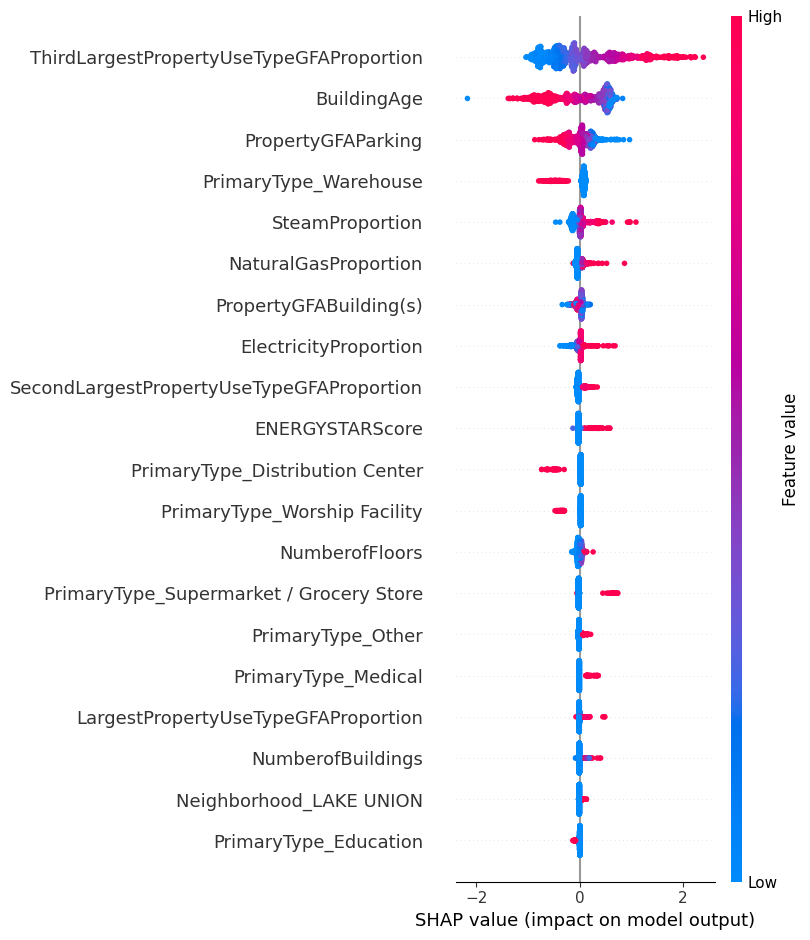

In [46]:
# Calculer les valeurs SHAP
explainer = shap.TreeExplainer(xgb_estimator)
shap_values = explainer.shap_values(X_train_ESS)

plt.figure(figsize=(2, 2)) 
shap.summary_plot(shap_values, X_train_ESS, plot_type="dot", show=False, plot_size='auto')
plt.show()

In [47]:
# Obtenir les valeurs SHAP moyennes par caractéristique
shap_summary_df = pd.DataFrame(shap_values, columns=X_train_ESS.columns)
shap_summary = shap_summary_df.mean()
shap_summary_sorted = shap_summary.sort_values(ascending=False)
print(shap_summary_sorted)

ThirdLargestPropertyUseTypeGFAProportion     0.005524
SteamProportion                              0.005183
PrimaryType_Worship Facility                 0.003541
NaturalGasProportion                         0.002350
PropertyGFABuilding(s)                       0.001811
PrimaryType_Warehouse                        0.001298
LargestPropertyUseTypeGFAProportion          0.000830
PrimaryType_Hotel                            0.000657
PrimaryType_Distribution Center              0.000563
PrimaryType_Medical                          0.000456
NumberofBuildings                            0.000440
Neighborhood_SOUTHWEST                       0.000422
PrimaryType_Office                           0.000368
Neighborhood_DOWNTOWN                        0.000252
PrimaryType_Mixed Use Property               0.000186
PrimaryType_Restaurant                       0.000148
PrimaryType_Education                        0.000133
PrimaryType_Other                            0.000065
Neighborhood_NORTHEAST      

XGBoost Regressor with Top SHAP Features - R2: 0.66, RMSE: 0.70, MSE: 0.49, MAE: 0.52
Training Time (XGBoost Regressor with Top SHAP Features): 0.23 seconds



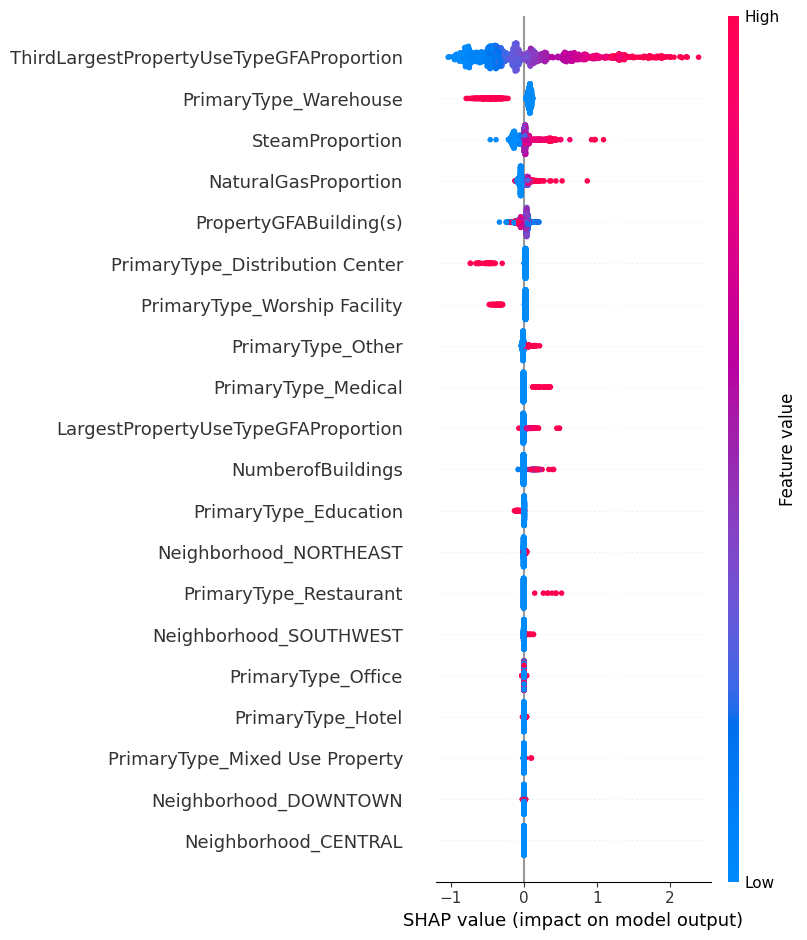

In [48]:
# Sélection des features les plus importantes selon SHAP
top_shap_features = shap_values.mean(0).argsort()[::-1][:20] 
X_train_top_shap_features = X_train_ESS.iloc[:, top_shap_features]
X_test_top_shap_features = X_test_ESS.iloc[:, top_shap_features]

xgb_estimator_top_shap = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_top_shap, y_pred_xgb_ESS_top_shap = train_and_predict(xgb_estimator_top_shap, X_train_top_shap_features, y_train_ESS, X_test_top_shap_features)
evaluate_model(y_test_ESS, y_pred_xgb_ESS_top_shap, "XGBoost Regressor with Top SHAP Features", training_time_xgb_top_shap)

### Feature Importance du Modèle :
- _**ThirdLargestPropertyUseTypeGFAProportion**_ et _**PrimaryType_Warehouse**_ : Ces caractéristiques semblent être les plus importantes selon cette méthode (respectivement 0.232803 et 0.162374). 
- _**BuildingAge**_ : Cette caractéristique contribue également à la prédiction, mais elle a une importance relativement plus faible (0.130465).
- _**ENERGYSTARScore**_ est loin derrière avec 0.015885
  
L'évaluation du modèle tenant compte des 20 features les plus importante selon feature_importance montre des performances similaires au modèle initial en termes de R2, RMSE, MSE et MAE. Cela indique que la sélection de caractéristiques basée sur l'importance des caractéristiques n'a pas beaucoup affecté les performances du modèle. Cependant, on observe que le temps d'entraînement est plus court avec la réduction des features. Cela peut être dû au fait que la sélection de caractéristiques réduit la dimensionnalité des données, ce qui peut accélérer l'entraînement du modèle.

### SHAP (SHapley Additive exPlanations) :
En se basant sur les valeurs moyennes des caractéristiques :
- _**ThirdLargestPropertyUseTypeGFAProportion**_ et _**SteamProportion**_ : Ces deux caractéristiques sont les plus importantes selon la méthode SHAP, elles ont un impact positif sur la prédiction (respectivement 0.005524 et 0.005183).
- _**PrimaryType_Worship_Facility**_, _**NaturalGasProportion**_ : Ces caractéristiques ont également un impact sur la prédiction, mais d'un ordre beaucoup plus faible (respectivement 0.003541 et 0.002350).

L'évaluation du modèle en tenant compte des features importantes selon SHAP a montré une baisse significative de R2 (0.66 contre 0.82 pour le modèle initial), ce qui indique une moins bonne adéquation aux données de test. De plus, le RMSE, MSE et MAE sont tous plus élevés dans ce modèle, indiquant des erreurs de prédiction plus importantes. Cela suggère que la sélection des caractéristiques basée sur SHAP n'a pas réussi à capturer les informations essentielles pour la prédiction, ce qui a conduit à une performance inférieure du modèle.

### Conclusion :
Bien que les deux méthodes identifient ThirdLargestPropertyUseTypeGFAProportion comme une caractéristique importante, l'ordre et l'importance relative des autres caractéristiques peuvent varier en fonction de la méthode utilisée.
La sélection de caractéristiques basée sur SHAP a conduit à une baisse significative des performances du modèle. 

## VII- Conclusion générale

En conclusion, ce projet de modélisation des émissions de CO2 et de la consommation d'énergie des bâtiments non destinés à l'habitation pour la ville de Seattle a été une mission complexe mais fructueuse. À travers un processus rigoureux de nettoyage des données, de prétraitement, de modélisation et d'évaluation, nous avons pu obtenir des résultats prometteurs.

Nous avons constaté que le modèle XGBoost Regressor s'est avéré être le plus performant pour la prédiction de nos deux variables cibles. De plus, l'ajout de l'EnergyStarScore comme variable explicative a conduit à une amélioration notable des performances des modèle, ce qui souligne l'importance de prendre en compte la performance énergétique globale des bâtiments.

L'analyse des features_importance a révélé des résultats intéressants, mettant en lumière des variables non soupçonnées comme ayant un impact significatif sur nos prédictions. Cependant, malgré les avantages de la méthode SHAP pour évaluer l'importance des caractéristiques, son application n'a pas conduit à des améliorations substantielles dans nos modèles.

En définitive, nous pouvons prédire les tendances de consommation d'énergie et les émissions de CO2 pour les prochaines années, ce qui est essentiel pour élaborer des stratégies visant à réduire l'empreinte carbone de Seattle et à progresser vers une ville neutre en émissions de carbone d'ici 2050.






